# Feature engineering on extracted Pull Requests data


## What we did previously

In the previous [notebook](./01_data_collection.ipynb) we collected data from a Github repository of choice and store them on S3 storage

## In this step

In this notebook we will walk through how to start analyzing the PR data collected from a Github repository.

We explore the various fields in the PR dataset and the features that we can derive from them in order to frame an a Machine Learning where we predict the time taken to merge a PR.

In [1]:
import os
import re
import gzip
import json
import boto3
import trino
import pathlib
import datetime
from tqdm import tqdm
from io import BytesIO
from pathlib import Path
from functools import partial
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif

from dotenv import load_dotenv, find_dotenv

In [2]:
class CephCommunication:
    """
    Class to establish communication with a ceph s3 bucket.
    It connects with the bucket and provides methods to read and write data in the parquet format.
    """

    def __init__(
        self, s3_endpoint_url, aws_access_key_id, aws_secret_access_key, s3_bucket
    ):
        self.s3_endpoint_url = s3_endpoint_url
        self.aws_access_key_id = aws_access_key_id
        self.aws_secret_access_key = aws_secret_access_key
        self.s3_resource = boto3.resource(
            "s3",
            endpoint_url=self.s3_endpoint_url,
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key,
        )
        self.bucket = s3_bucket
        ## Todo: Add try catch

    def upload_to_ceph(self, dataframe, s3_path, filename):
        """
        This helper function takes as input the data frame to be uploaded, and the output filename.
        It then saves the data frame in the defined ceph bucket.
        """
        parquet_buffer = BytesIO()
        dataframe.to_parquet(parquet_buffer)
        s3_obj = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        status = s3_obj.put(Body=parquet_buffer.getvalue())
        return status

    def read_from_ceph(self, s3_path, filename):
        """
        Helper function to read from ceph and see if the saved data is correct.
        """
        buffer = BytesIO()
        s3_object = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        s3_object.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer)
        return df_temp


def save_to_disk(dataframe, path, filename):
    """
    Helper function to save the dataframe
    as a parquet file to disk.
    """
    dataset_base_path = Path(path)
    dataset_base_path.mkdir(parents=True, exist_ok=True)
    dataframe.to_parquet(f"{path}/{filename}")
    return True

In [3]:
sns.set(rc={"figure.figsize": (20, 10)})
load_dotenv(find_dotenv(), override=True)

True

In [4]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,

ORG = os.getenv("GITHUB_ORG")
REPO = os.getenv("GITHUB_REPO")

## S3 bucket credentials
s3_endpoint_url = os.getenv("S3_ENDPOINT_URL")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

REMOTE = os.getenv("REMOTE")

s3_input_data_path = os.getenv("CEPH_BUCKET_PREFIX")
local_input_data_path = "../../../data/raw/GitHub/PullRequest.json.gz"
local_output_data_path = "../../../data/processed/github"
RAW_DATA_PATH = os.path.join(
    s3_input_data_path, "srcopsmetrics/bot_knowledge", ORG, REPO, "PullRequest.json"
)

## Trino
SQL_TABLE_FILENAME = os.path.join(ORG + REPO + "prs.parquet")
SQL_TABLE_KEY = os.path.join(s3_input_data_path, ORG, REPO, "sql")

In [5]:
output = []
if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, RAW_DATA_PATH)
    file = content.get()["Body"].read().decode("utf-8")

    prs = json.loads(file)

    for pr in prs.splitlines():
        output.append(json.loads(pr))

else:
    print("getting dataset from local")
    with gzip.open(local_input_data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))

pr_df = pd.DataFrame(output)

getting dataset from ceph


In [6]:
pr_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Update wording to be more open and inclusive.,Updates as worked out with Karsten\r\n,XS,billburnseh,1663618828,1.663619e+09,billburnseh,1.663619e+09,billburnseh,2,1,{'sesheta': 86},{},[size/XS],"[c86790d3a173abae0682dcbef583e6b151d6e61c, 272...",[four-principles.md],NaN,NaN,223
1,office hours,- add office hours\n- ran the markdown generat...,M,durandom,1663080364,1.663080e+09,durandom,1.663080e+09,durandom,1,8,{'sesheta': 144},{},"[do-not-merge/invalid-owners-file, size/M]",[c10b264bd795ac3110035bef51fef9e50a63f782],"[OWNERS_ALIASES, README.md, sig-data-science/R...",NaN,NaN,222
2,add office hours,None,XS,durandom,1663079586,1.663080e+09,durandom,1.663080e+09,durandom,1,1,{'sesheta': 73},{},[size/XS],[efd3f71fd62d499114dda31998e479d647c2f49b],[sig-operations/README.md],NaN,NaN,221
3,Inputing & evolving four principles,Putting in Nick's original four principles fro...,S,quaid,1662563897,1.662646e+09,billburnseh,1.662646e+09,billburnseh,2,1,"{'sesheta': 73, 'nijaba': 13, 'billburnseh': 3...","{'1099380890': {'author': 'quaid', 'words_coun...","[lgtm, size/S]","[e95de46b7b7c7ec2bc7d770610c2f1dea08eac39, d68...",[four-principles.md],1.662564e+09,NaN,220
4,Clean-up and addition of how-to-naming details,Lots of cruft and old discussion material remo...,L,quaid,1661802832,NaN,None,NaN,None,1,1,{'sesheta': 73},{},[size/L],[a173025d28af4b84c657f17c3de5f9e7ba6061b5],[glossary.md],NaN,NaN,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Created a new document for glossary,This pr adds a glossary document to the repo. ...,L,margarethaley,1625255261,1.625615e+09,sesheta,1.625615e+09,sesheta,2,2,"{'quaid': 4, 'sesheta': 65}","{'699550191': {'author': 'quaid', 'words_count...","[size/L, lgtm, approved]","[28612661c6aa3a338539176e3bef111537e8b79e, f4c...","[glossary.md, new_front_page_mockup.md]",1.625550e+09,NaN,45
86,update the resource limit for the prowjobs,update the resource limit for the prowjobs\r\n...,XS,harshad16,1625177628,1.625230e+09,sesheta,1.625230e+09,sesheta,1,1,"{'harshad16': 3, 'sesheta': 70}","{'698155981': {'author': 'oindrillac', 'words_...","[lgtm, approved, size/XS]",[d89f48d4fd7c01b61847762dfda0b2253cb0e7ed],[.prow.yaml],1.625230e+09,1.625230e+09,44
87,Front page content draft,This pr adds a file containing draft content f...,M,margarethaley,1625167660,1.625254e+09,sesheta,1.625254e+09,sesheta,1,1,"{'margarethaley': 24, 'oindrillac': 104, 'hars...","{'697796698': {'author': 'quaid', 'words_count...","[lgtm, approved, size/M]",[28612661c6aa3a338539176e3bef111537e8b79e],[new_front_page_mockup.md],1.625197e+09,NaN,43
88,Created from existing messages for hacking-on,This is created using the messages on operate-...,M,quaid,1621226623,1.625255e+09,sesheta,1.625255e+09,sesheta,1,1,"{'HumairAK': 60, 'quaid': 96, 'sesheta': 131, ...","{'661390364': {'author': 'HumairAK', 'words_co...","[lgtm, approved]",[03b73f88526078fdce85a6862248f2c8641e60d2],[core_project_message.md],1.621283e+09,NaN,5


In [7]:
pr_df.shape

(90, 19)

In [8]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Update wording to be more open and inclusive.,Updates as worked out with Karsten\r\n,XS,billburnseh,1663618828,1.663619e+09,billburnseh,1.663619e+09,billburnseh,2,1,{'sesheta': 86},{},[size/XS],"[c86790d3a173abae0682dcbef583e6b151d6e61c, 272...",[four-principles.md],NaN,NaN,223
1,office hours,- add office hours\n- ran the markdown generat...,M,durandom,1663080364,1.663080e+09,durandom,1.663080e+09,durandom,1,8,{'sesheta': 144},{},"[do-not-merge/invalid-owners-file, size/M]",[c10b264bd795ac3110035bef51fef9e50a63f782],"[OWNERS_ALIASES, README.md, sig-data-science/R...",NaN,NaN,222


## Inspect the dataset

Let's unroll a single row and see what kind of information we have access to. 

In [9]:
pr = pr_df.iloc[10]
pr

title                                  Create 2022-07-26_meeting-nodes.md
body                    and renaming the last meeting nodes, removing ...
size                                                                    S
created_by                                                       schwesig
created_at                                                     1658856014
closed_at                                                    1658856128.0
closed_by                                                        schwesig
merged_at                                                    1658856128.0
merged_by                                                        schwesig
commits_number                                                          3
changed_files_number                                                    2
interactions                              {'sesheta': 211, 'schwesig': 7}
reviews                 {'1051361742': {'author': 'schwesig', 'words_c...
labels                  [kind/document

</br>

#### **Available Fields**

* **title**: text providing a short description of the of the PR.

* **body**: text providing additional details regarding the changes. 

* **size**: categorical label generated by GitHub summerizing the size of the changes made to the code base. 

* **created/closed/merged_at**: timestamps for when the PR was opened, merged and finally closed. 

* **created/closed_by**: usernames for contributors who created the PR and closed it. 

* **commits_number**: integer indicating the number of commits in the PR.

* **changed_files_number**: integer indicating the number of files changed.

The remaining fields appear to be collections of items, let's unroll each one and see what additional information they provide.


In [10]:
pr["interactions"]

{'sesheta': 211, 'schwesig': 7}

**interactions**: a dictionary with usernames for keys and the number of times they interacted with the PR as the value.

In [11]:
pr["reviews"]

{'1051361742': {'author': 'schwesig',
  'words_count': 1,
  'submitted_at': 1658856048,
  'state': 'COMMENTED'}}

**reviews**: a dictionary of reviews that includes an id number key along with fields for author, word_count, submitted timestamp and state of review.

In [12]:
pr["labels"]

['kind/documentation', 'approved', 'size/S', 'kind/website', 'sig/community']

**labels**: a list of labels tagged to the PR describing some of its attributes

In [13]:
pr["commits"]

['2ce8850d7152b21579f018f3872181b3117114e3',
 'f9e2421096b51ddfc33ac7a8f8a5ade755ebb694',
 '35500cde0494d78dcb8e2e02559fea4cad6e89ab']

**commits**: a list of commit hashes that point to specific changes made to the repo's history

In [14]:
print(len(pr["changed_files"]))
pr["changed_files"][0:10]

2


['sig-community/wg-website-updates/meeting-notes/20220719_meeting-nodes.md',
 'sig-community/wg-website-updates/meeting-notes/20220726_meeting-nodes.md']

**changed_files**: a list of the paths and filenames for every file changed by this PR.

We now know what we have access to in this dataset. It is a collection of numerical, categorical and textual features used to describe a PR. This gives us a lot of potential avenues to explore from an EDA and Data Science perspective. But is also creates an additional challenge insofar as we'll need to do a bit of feature engineering to get this data into format that is ready to be ingested by any ML models. 

## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [15]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].astype("float")
# NOTE: we cant fill NA with 0 because that would imply the PR got merged instantaneously

In [16]:
pr_df["time_to_merge"]

0          11.0
1          20.0
2          15.0
3       82496.0
4           NaN
        ...    
85     359974.0
86      52870.0
87      86385.0
88    4028019.0
89      16676.0
Name: time_to_merge, Length: 90, dtype: float64

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [17]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0     0.592105
4.0     0.052632
5.0     0.026316
24.0    0.026316
7.0     0.026316
14.0    0.026316
28.0    0.026316
12.0    0.026316
10.0    0.013158
6.0     0.013158
35.0    0.013158
27.0    0.013158
21.0    0.013158
9.0     0.013158
8.0     0.013158
15.0    0.013158
2.0     0.013158
26.0    0.013158
18.0    0.013158
13.0    0.013158
44.0    0.013158
3.0     0.013158
47.0    0.013158
Name: time_to_merge, dtype: float64

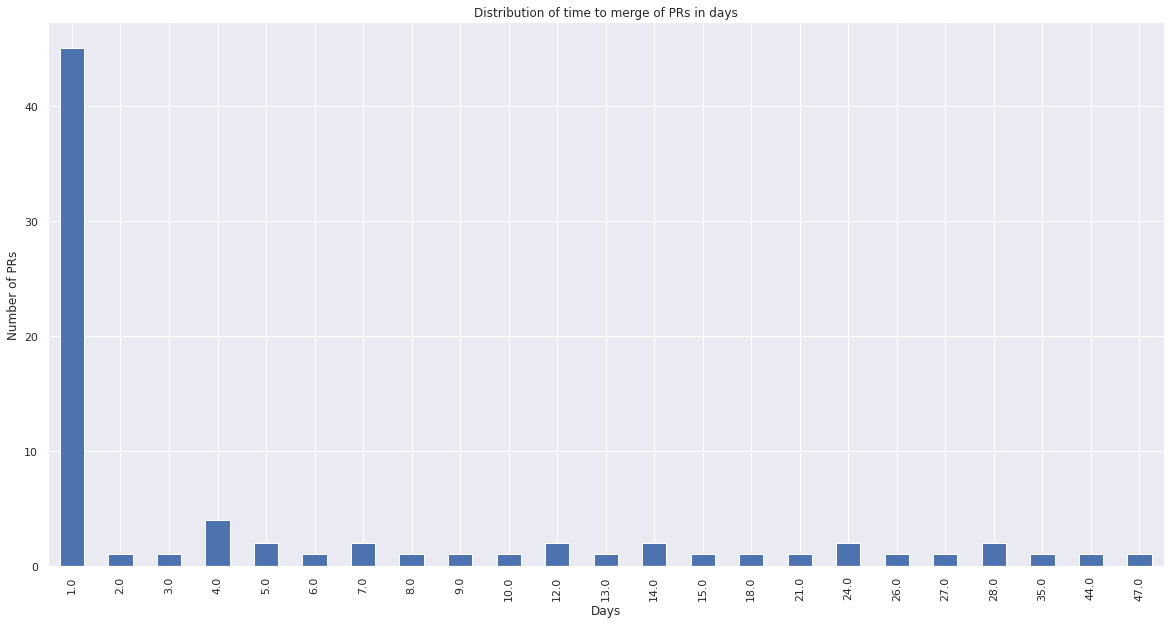

In [18]:
# only plot top 100 values so that graph is legible
vc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("Days")
plt.ylabel("Number of PRs")
plt.title("Distribution of time to merge of PRs in days")
plt.show()

In [19]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.328947
6.0      0.065789
5.0      0.039474
8.0      0.039474
7.0      0.039474
2.0      0.039474
217.0    0.026316
4.0      0.026316
25.0     0.026316
96.0     0.026316
50.0     0.013158
55.0     0.013158
34.0     0.013158
37.0     0.013158
46.0     0.013158
280.0    0.013158
30.0     0.013158
212.0    0.013158
3.0      0.013158
164.0    0.013158
65.0     0.013158
74.0     0.013158
118.0    0.013158
189.0    0.013158
112.0    0.013158
9.0      0.013158
58.0     0.013158
22.0     0.013158
346.0    0.013158
205.0    0.013158
185.0    0.013158
144.0    0.013158
106.0    0.013158
102.0    0.013158
32.0     0.013158
373.0    0.013158
Name: time_to_merge, dtype: float64

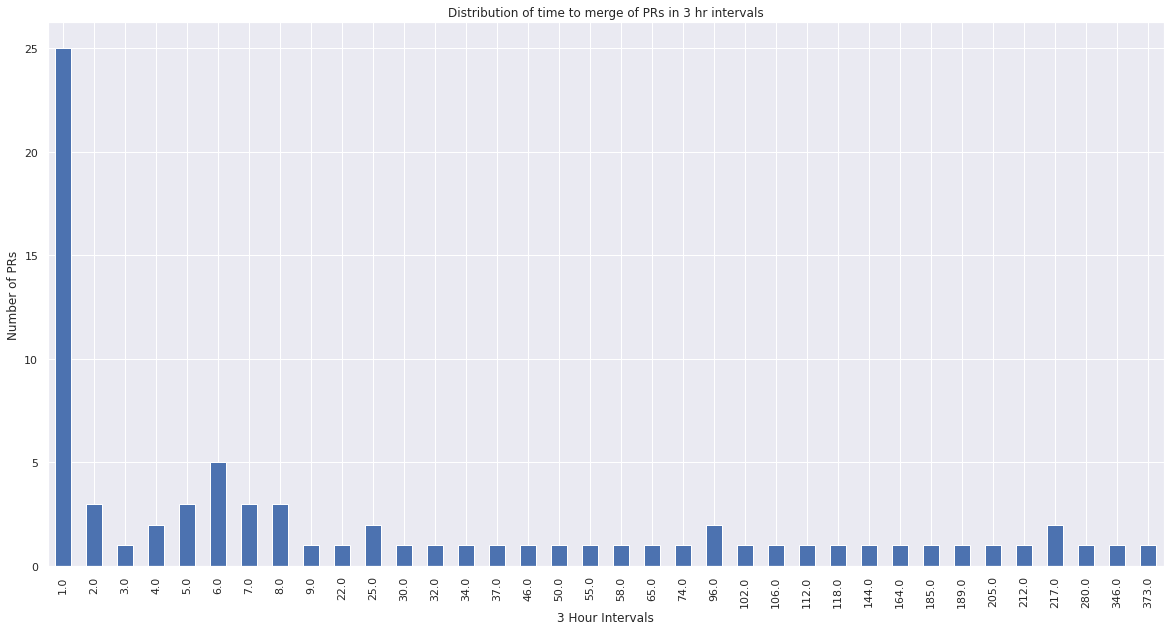

In [20]:
# only plot top 100 values so that graph is legible
vc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("3 Hour Intervals")
plt.ylabel("Number of PRs")
plt.title("Distribution of time to merge of PRs in 3 hr intervals")
plt.show()

In [21]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0       0.302632
16.0      0.039474
17.0      0.026316
5.0       0.026316
73.0      0.026316
15.0      0.026316
635.0     0.013158
354.0     0.013158
165.0     0.013158
220.0     0.013158
193.0     0.013158
490.0     0.013158
8.0       0.013158
651.0     0.013158
12.0      0.013158
88.0      0.013158
26.0      0.013158
649.0     0.013158
838.0     0.013158
137.0     0.013158
111.0     0.013158
21.0      0.013158
19.0      0.013158
100.0     0.013158
24.0      0.013158
335.0     0.013158
2.0       0.013158
3.0       0.013158
304.0     0.013158
288.0     0.013158
66.0      0.013158
1038.0    0.013158
555.0     0.013158
4.0       0.013158
565.0     0.013158
148.0     0.013158
96.0      0.013158
287.0     0.013158
23.0      0.013158
317.0     0.013158
432.0     0.013158
11.0      0.013158
615.0     0.013158
13.0      0.013158
20.0      0.013158
22.0      0.013158
173.0     0.013158
1119.0    0.013158
Name: time_to_merge, dtype: float64

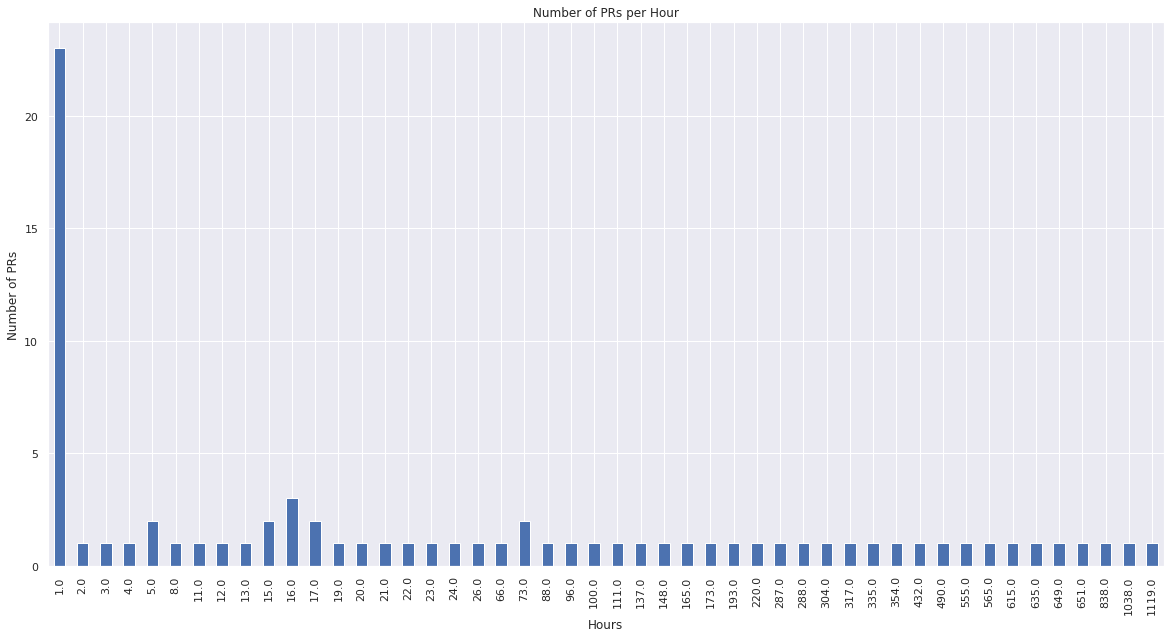

In [22]:
# only plot top 100 values so that graph is legible
vc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("Hours")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per Hour")
plt.show()

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [23]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0      0.003056
0.1      0.012361
0.2      0.060833
0.3      1.016528
0.4     11.225000
0.5     16.645833
0.6     25.391944
0.7    123.672222
0.8    287.083611
0.9    559.429444
Name: time_to_merge, dtype: float64

In [24]:
intervals = quantiles

In [25]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0           NaN
0.1      0.009306
0.2      0.048472
0.3      0.955694
0.4     10.208472
0.5      5.420833
0.6      8.746111
0.7     98.280278
0.8    163.411389
0.9    272.345833
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, we can use the above buckets to define the classes.

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [26]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [27]:
pr_df["body_size"]

0      6
1      9
2      0
3     20
4     22
      ..
85    48
86    16
87    38
88    34
89     3
Name: body_size, Length: 90, dtype: int64

**Size**

We can attempt to convert the categorical size label generated by GitHub, which summarizes the size of the changes made to the code base, to a numerical value. 

In [28]:
set(pr_df['size'])

{'L', 'M', 'S', 'XL', 'XS', 'XXL'}

In [29]:
convert_size = {"size": {"NaN": 0, "XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5}}
pr_df = pr_df.replace(convert_size)

**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [30]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

0      update wording to be more open and inclusive 
1                                       office hours
2                                   add office hours
3                inputing   evolving four principles
4     clean up and addition of how to naming details
                           ...                      
85               created a new document for glossary
86        update the resource limit for the prowjobs
87                          front page content draft
88     created from existing messages for hacking on
89                        chore  add quaid to owners
Name: title, Length: 90, dtype: object

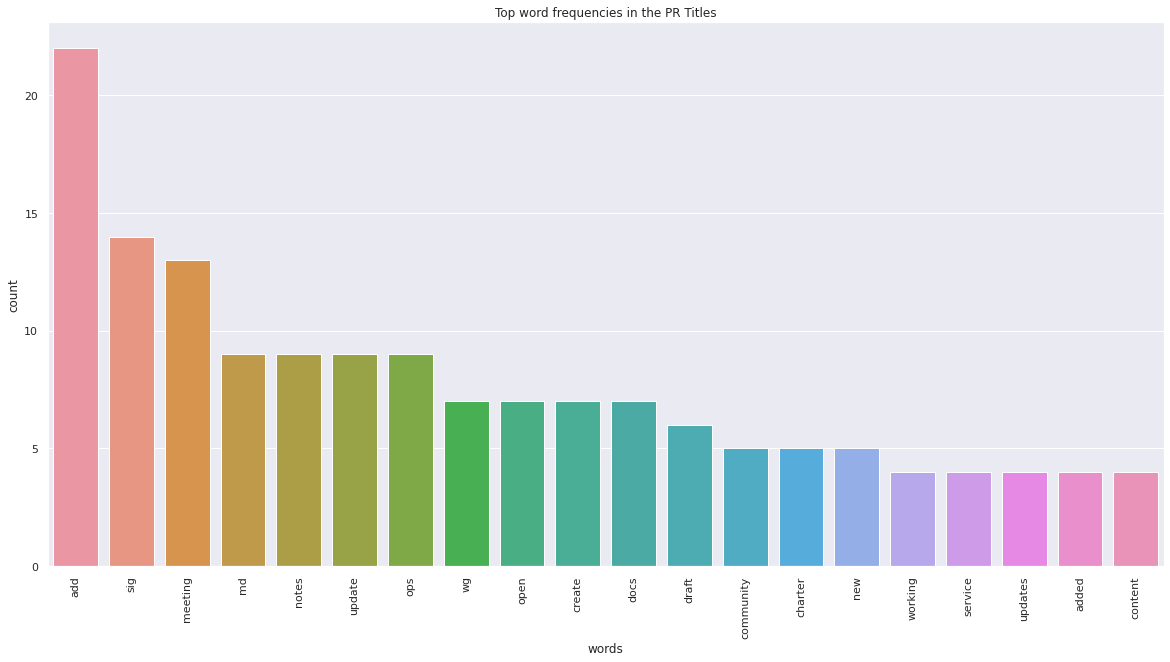

In [31]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

# plot the 20 most common words
sns.barplot(
    x=vc.index[:20],
    y=vc.values[:20],
)
plt.xticks(rotation=90)
plt.title("Top word frequencies in the PR Titles")
plt.xlabel("words")
plt.ylabel("count")
plt.show()

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [32]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

  0%|          | 0/221 [00:00<?, ?it/s]<ipython-input-32-b5d3ebcc227c>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
 44%|████▍     | 97/221 [00:00<00:00, 411.69it/s]<ipython-input-32-b5d3ebcc227c>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
<ipython-input-32-b5d3ebcc227c>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [33]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [34]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
)
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())

# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [35]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_approve_at,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Update wording to be more open and inclusive.,Updates as worked out with Karsten\r\n,0,billburnseh,1663618828,1.663619e+09,billburnseh,1.663619e+09,billburnseh,2,...,NaN,223,11.0,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-09-19 20:20:28,19,9,0,20
1,office hours,- add office hours\n- ran the markdown generat...,2,durandom,1663080364,1.663080e+09,durandom,1.663080e+09,durandom,1,...,NaN,222,20.0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-09-13 14:46:04,13,9,1,14


**Commits Number**  
Commits Number gives the number of commits created within the PR. This could be a numerical feature for our model.

In [36]:
pr_df.commits_number.value_counts()

1     62
2     15
3      5
0      2
8      1
7      1
14     1
20     1
5      1
4      1
Name: commits_number, dtype: int64

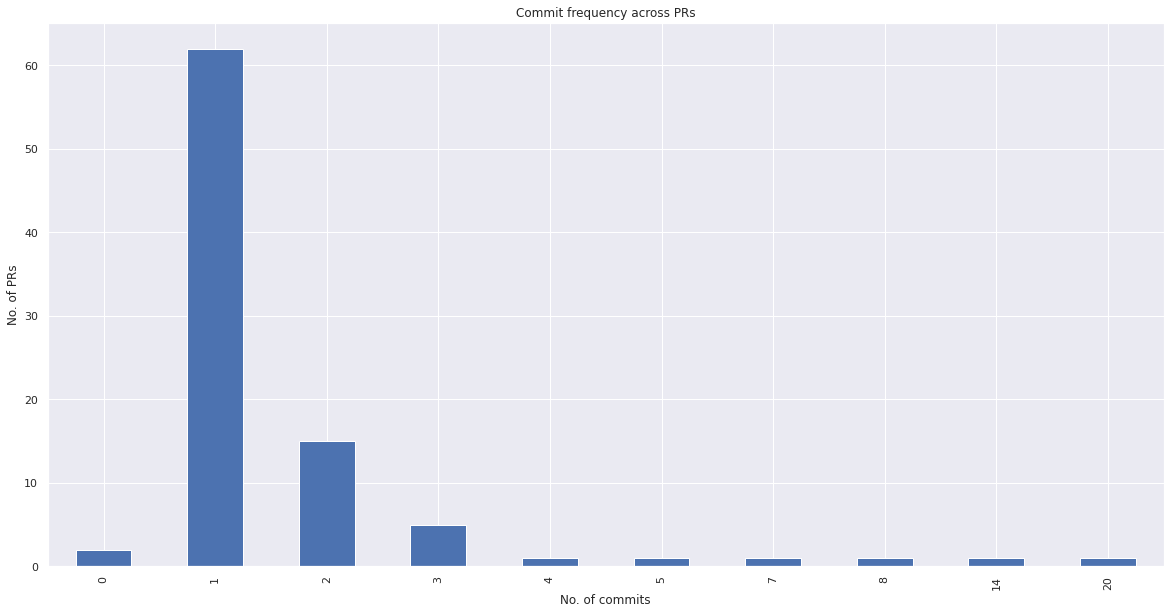

In [37]:
pr_df.commits_number.value_counts().sort_index(ascending=True).plot(kind="bar")
plt.title("Commit frequency across PRs")
plt.xlabel("No. of commits")
plt.ylabel("No. of PRs")
plt.show()

In [38]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_approve_at,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Update wording to be more open and inclusive.,Updates as worked out with Karsten\r\n,0,billburnseh,1663618828,1.663619e+09,billburnseh,1.663619e+09,billburnseh,2,...,NaN,223,11.0,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-09-19 20:20:28,19,9,0,20
1,office hours,- add office hours\n- ran the markdown generat...,2,durandom,1663080364,1.663080e+09,durandom,1.663080e+09,durandom,1,...,NaN,222,20.0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-09-13 14:46:04,13,9,1,14


**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [39]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1     52
2     17
3      5
5      3
6      3
0      3
8      2
7      2
4      1
12     1
17     1
Name: changed_files_number, dtype: int64

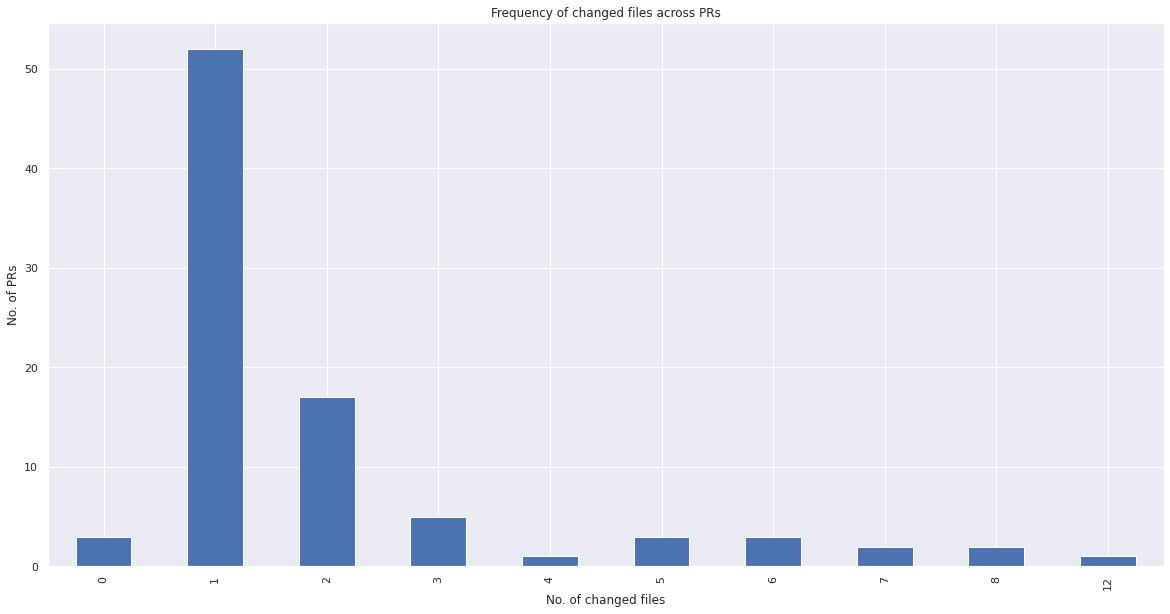

In [40]:
pr_df.changed_files_number.value_counts().iloc[:10].sort_index(ascending=True).plot(
    kind="bar"
)
plt.title("Frequency of changed files across PRs")
plt.xlabel("No. of changed files")
plt.ylabel("No. of PRs")
plt.show()

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [41]:
pr_df.changed_files

0                                  [four-principles.md]
1     [OWNERS_ALIASES, README.md, sig-data-science/R...
2                            [sig-operations/README.md]
3                                  [four-principles.md]
4                                         [glossary.md]
                            ...                        
85              [glossary.md, new_front_page_mockup.md]
86                                         [.prow.yaml]
87                           [new_front_page_mockup.md]
88                            [core_project_message.md]
89                                             [OWNERS]
Name: changed_files, Length: 90, dtype: object

In [42]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [43]:
# get list of all file types that were modified across all openshift origin PRs
changed_files = list(pr_df["changed_files"])

In [44]:
all_changed_files = [filetype(filepath) for pr in changed_files for filepath in pr]

In [45]:
count = Counter(all_changed_files)

In [46]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [47]:
top_fileextensions

['.md',
 '.yaml',
 '.tmpl',
 'OWNERS',
 'OWNERS_ALIASES',
 '.yml',
 '.ipynb',
 '.png',
 '.txt',
 '.json']

In [48]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [49]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [50]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
0,Update wording to be more open and inclusive.,Updates as worked out with Karsten\r\n,0,billburnseh,1663618828,1.663619e+09,billburnseh,1.663619e+09,billburnseh,2,...,223,11.0,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-09-19 20:20:28,19,9,0,20,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,office hours,- add office hours\n- ran the markdown generat...,2,durandom,1663080364,1.663080e+09,durandom,1.663080e+09,durandom,1,...,222,20.0,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-09-13 14:46:04,13,9,1,14,"[6, 1, 0, 0, 1, 0, 0, 0, 0, 0]"


## Create PR trends dashboard

### SQL-ify columns for creating SQL Tables from the dataframe

In [51]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  90 non-null     object        
 1   body                   82 non-null     object        
 2   size                   90 non-null     int64         
 3   created_by             90 non-null     object        
 4   created_at             90 non-null     int64         
 5   closed_at              80 non-null     float64       
 6   closed_by              80 non-null     object        
 7   merged_at              76 non-null     float64       
 8   merged_by              76 non-null     object        
 9   commits_number         90 non-null     int64         
 10  changed_files_number   90 non-null     int64         
 11  interactions           90 non-null     object        
 12  reviews                90 non-null     object        
 13  labels 

In [52]:
cols_to_drop = [
    "interactions",
    "reviews",
    "labels",
    "commits",
    "changed_files",
    "title_word_counts_vec",
    "changed_file_type_vec",
]
sql_df = pr_df.drop(columns=cols_to_drop)
sql_df.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_review_at,first_approve_at,id,time_to_merge,body_size,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,Update wording to be more open and inclusive.,Updates as worked out with Karsten\r\n,0,billburnseh,1663618828,1.663619e+09,billburnseh,1.663619e+09,billburnseh,2,...,NaN,NaN,223,11.0,6,2022-09-19 20:20:28,19,9,0,20
1,office hours,- add office hours\n- ran the markdown generat...,2,durandom,1663080364,1.663080e+09,durandom,1.663080e+09,durandom,1,...,NaN,NaN,222,20.0,9,2022-09-13 14:46:04,13,9,1,14
2,add office hours,None,0,durandom,1663079586,1.663080e+09,durandom,1.663080e+09,durandom,1,...,NaN,NaN,221,15.0,0,2022-09-13 14:33:06,13,9,1,14
3,Inputing & evolving four principles,Putting in Nick's original four principles fro...,1,quaid,1662563897,1.662646e+09,billburnseh,1.662646e+09,billburnseh,2,...,1.662564e+09,NaN,220,82496.0,20,2022-09-07 15:18:17,7,9,2,15
4,Clean-up and addition of how-to-naming details,Lots of cruft and old discussion material remo...,3,quaid,1661802832,NaN,None,NaN,None,1,...,NaN,NaN,219,NaN,22,2022-08-29 19:53:52,29,8,0,19


In [53]:
sql_df = sql_df.infer_objects()

In [54]:
# convert to timestamps
ts_cols = ["created_at", "closed_at", "merged_at"]

for c in ts_cols:
    sql_df[c] = pd.to_datetime(sql_df[c], unit="s")

In [55]:
sql_df.dtypes

title                           object
body                            object
size                             int64
created_by                      object
created_at              datetime64[ns]
closed_at               datetime64[ns]
closed_by                       object
merged_at               datetime64[ns]
merged_by                       object
commits_number                   int64
changed_files_number             int64
first_review_at                float64
first_approve_at               float64
id                              object
time_to_merge                  float64
body_size                        int64
created_at_datetime     datetime64[ns]
created_at_day                   int64
created_at_month                 int64
created_at_weekday               int64
created_at_hour                  int64
dtype: object

## Infer dataframe columns as Features

We can see above that some PRs have 0 for all directory fields since the directory structure of the repo has changed over time and we are interested in only the latest directory structure.

In [56]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "size",
        "title_word_counts_vec",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
    ]
]

### Add PR TTM Class Column 

Lets split up the time to merge values into 10 discrete bins (as discussed above) to use as our prediction classes.

In [57]:
intervals

0.0         11.0
0.1         44.5
0.2        219.0
0.3       3659.5
0.4      40410.0
0.5      59925.0
0.6      91411.0
0.7     445220.0
0.8    1033501.0
0.9    2013946.0
Name: time_to_merge, dtype: float64

In [58]:
def get_ttm_class(ttm):

    for rownum, (indx, val) in enumerate(intervals.iteritems()):
        if ttm < val:
            return rownum - 1
    return 9


feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)
feature_df.head()

<ipython-input-58-7e47c5f56ed7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)


,time_to_merge,changed_files_number,body_size,size,title_word_counts_vec,created_at_day,created_at_month,created_at_weekday,created_at_hour,commits_number,changed_file_type_vec,ttm_class
0,11.0,1,6,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19,9,0,20,2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
1,20.0,8,9,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,9,1,14,1,"[6, 1, 0, 0, 1, 0, 0, 0, 0, 0]",0
2,15.0,1,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,9,1,14,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
3,82496.0,1,20,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,9,2,15,2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5
4,NaN,1,22,3,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",29,8,0,19,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9


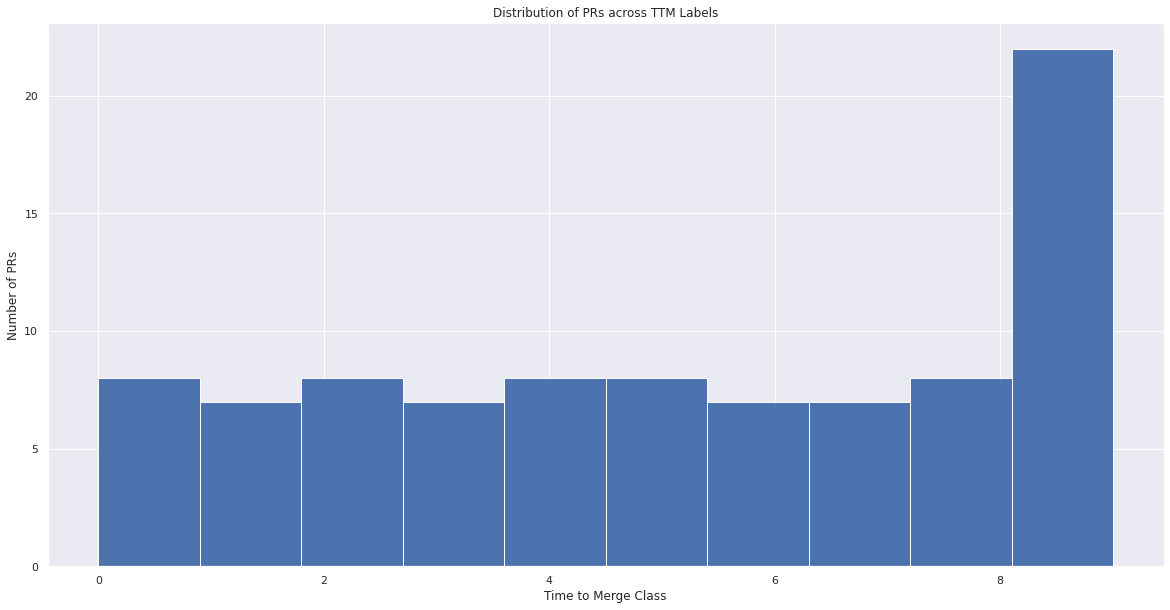

In [59]:
# visualize data points distribution across classes
feature_df["ttm_class"].hist()
plt.title("Distribution of PRs across TTM Labels")
plt.xlabel("Time to Merge Class")
plt.ylabel("Number of PRs")
plt.show()

From the above graph, we can see that data is fairly uniformly distributed across all classes. At the same time, the class definitions are also easily interpretable by human experts. So this seems like a good setup for our classification task.

Let's look at some pair-wise scatter plots of our data to see if there are any obvious correlations between our features. 

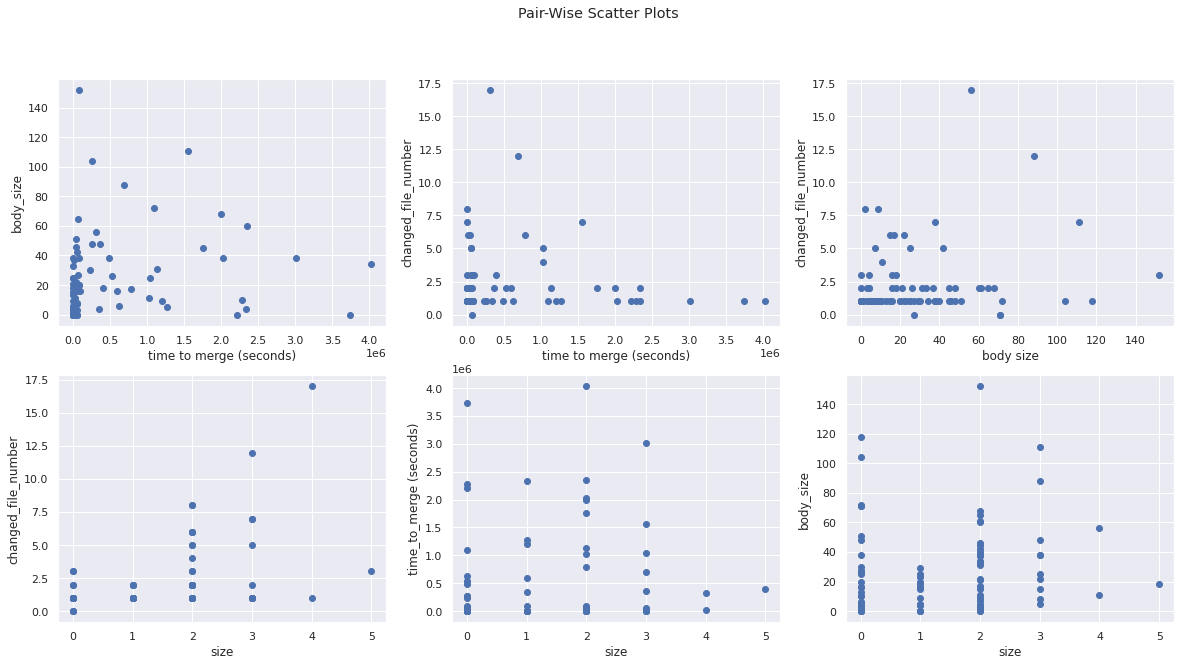

In [60]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
ax1.scatter(pr_df["time_to_merge"], pr_df["body_size"])
ax1.set(xlabel="time to merge (seconds)", ylabel="body_size")
ax2.scatter(pr_df["time_to_merge"], pr_df["changed_files_number"])
ax2.set(xlabel="time to merge (seconds)", ylabel="changed_file_number")
ax3.scatter(pr_df["body_size"], pr_df["changed_files_number"])
ax3.set(xlabel="body size", ylabel="changed_file_number")

ax4.scatter(pr_df["size"], pr_df["changed_files_number"])
ax4.set(xlabel="size", ylabel="changed_file_number")
ax5.scatter(pr_df["size"], pr_df["time_to_merge"])
ax5.set(xlabel="size", ylabel="time_to_merge (seconds)")
ax6.scatter(pr_df["size"], pr_df["body_size"])
ax6.set(xlabel="size", ylabel="body_size")

fig.suptitle("Pair-Wise Scatter Plots")
plt.show()

## Evaluating Feature Importances

### Categorical Features

First, lets try to determine what categorical featuers are powerful influencers for time to merge of a PR

In [61]:
# feature selection helper function
def select_features(x, y, func):
    fs = SelectKBest(score_func=func, k="all")
    fs.fit(x, y)
    x_fs = fs.transform(x)
    return x_fs, fs


selected_features = []

In [62]:
cat_features = [
    "size",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
    "ttm_class",
]

In [63]:
cat_df = feature_df[cat_features]

cat_df.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
0,0,19,9,0,20,0
1,2,13,9,1,14,0
2,0,13,9,1,14,0
3,1,7,9,2,15,5
4,3,29,8,0,19,9


In [64]:
# split into input (x) and output (y) variables
X_inp = cat_df.drop(columns=["ttm_class"])
y = cat_df["ttm_class"]

In [65]:
# rank using mutual_info_classif
X_fs, fs = select_features(X_inp, y, mutual_info_classif)

In [66]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 0.264955
Feature created_at_day: 0.356445
Feature created_at_month: 0.157339
Feature created_at_weekday: 0.106474
Feature created_at_hour: 0.045943


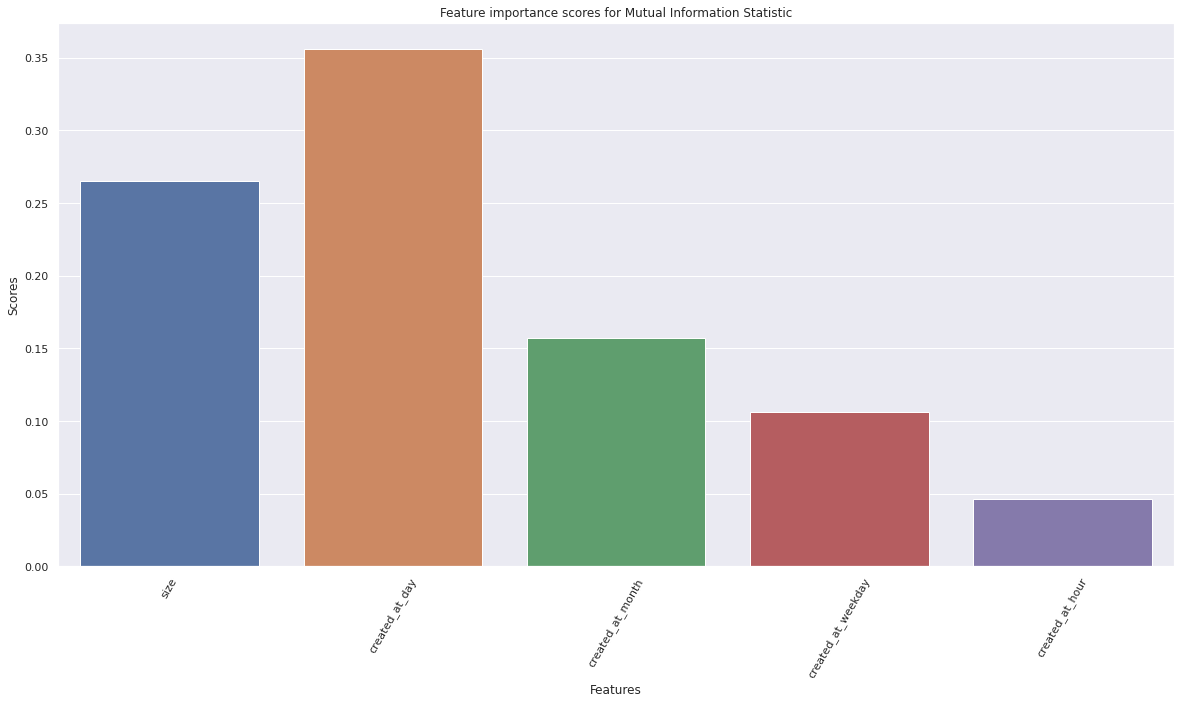

In [67]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Mutual Information Statistic")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [68]:
# Lets get a list of the top 10 feature indices based on Mutual Info Stat feature scores
top_mis = fs.scores_.argsort()[-10:][::-1]

In [69]:
# rank using chi_sq
X_fs, fs = select_features(X_inp, y, chi2)

In [70]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 8.742654
Feature created_at_day: 101.389185
Feature created_at_month: 26.748122
Feature created_at_weekday: 13.171076
Feature created_at_hour: 22.522598


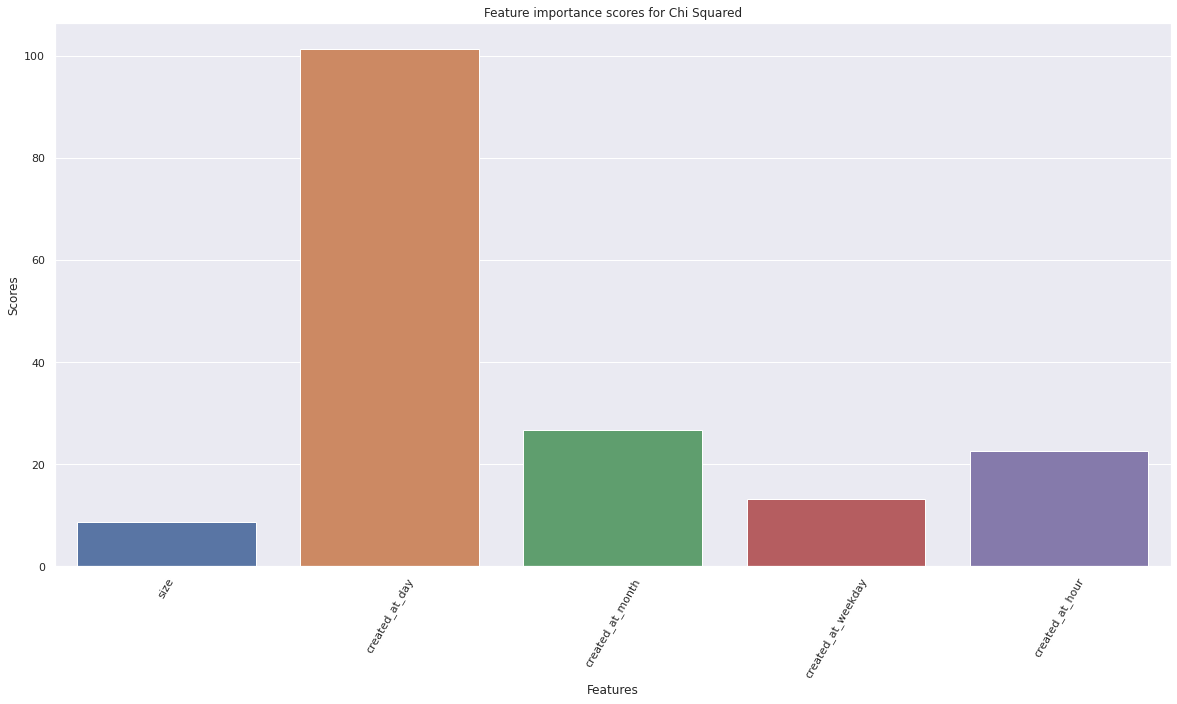

In [71]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Chi Squared")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [72]:
# Lets get a list of the top 10 feature indices based on Chi Sq feature scores
top_chi2 = fs.scores_.argsort()[-10:][::-1]

Let's get a Union of the top 10 features derived from features based on both scores of both Mutual Info Statistic and Chi Squared

In [73]:
union = set(top_mis).union(set(top_chi2))
print(len(union))
union

5


{0, 1, 2, 3, 4}

In [74]:
selected_cat_features = [cat_features[i] for i in union]
selected_cat_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour']

In [75]:
# update list of features to keep for training
selected_features += selected_cat_features

### Numerical Features

Now, lets try to determine what numerical featuers are powerful influencers for time to merge of a PR

In [76]:
numerical_features = [
    "changed_files_number",
    "body_size",
    "commits_number",
    "ttm_class",
]

In [77]:
numerical_df = feature_df[numerical_features]
numerical_df.head()

,changed_files_number,body_size,commits_number,ttm_class
0,1,6,2,0
1,8,9,1,0
2,1,0,1,0
3,1,20,2,5
4,1,22,1,9


In [78]:
# split into input features and target
X_inp = numerical_df.drop(columns=["ttm_class"])
y = numerical_df["ttm_class"]

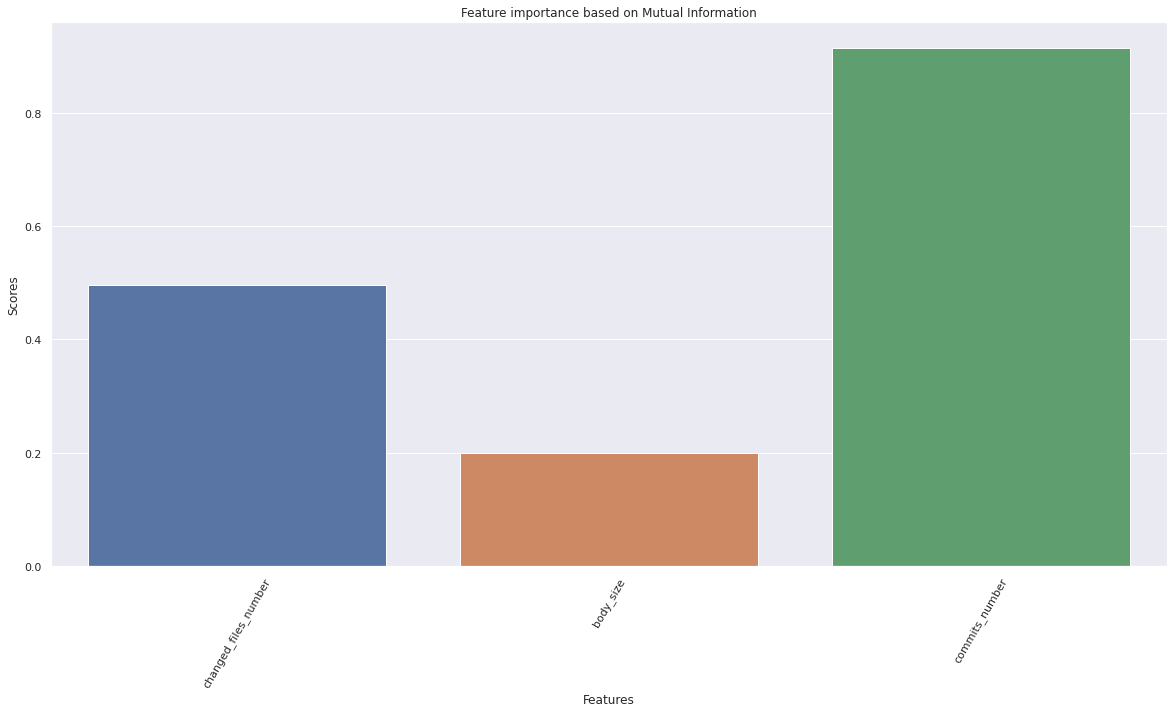

In [79]:
# create k best feature selector object based on mutual information
numerical_feats_mi, k_best_selector_mi = select_features(
    X_inp,
    y,
    partial(
        mutual_info_classif,
        discrete_features=False,
        random_state=42,
        n_neighbors=3,
    ),
)

# visualize the MI scores of all features
sns.barplot(x=X_inp.columns, y=k_best_selector_mi.scores_)
plt.title("Feature importance based on Mutual Information")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

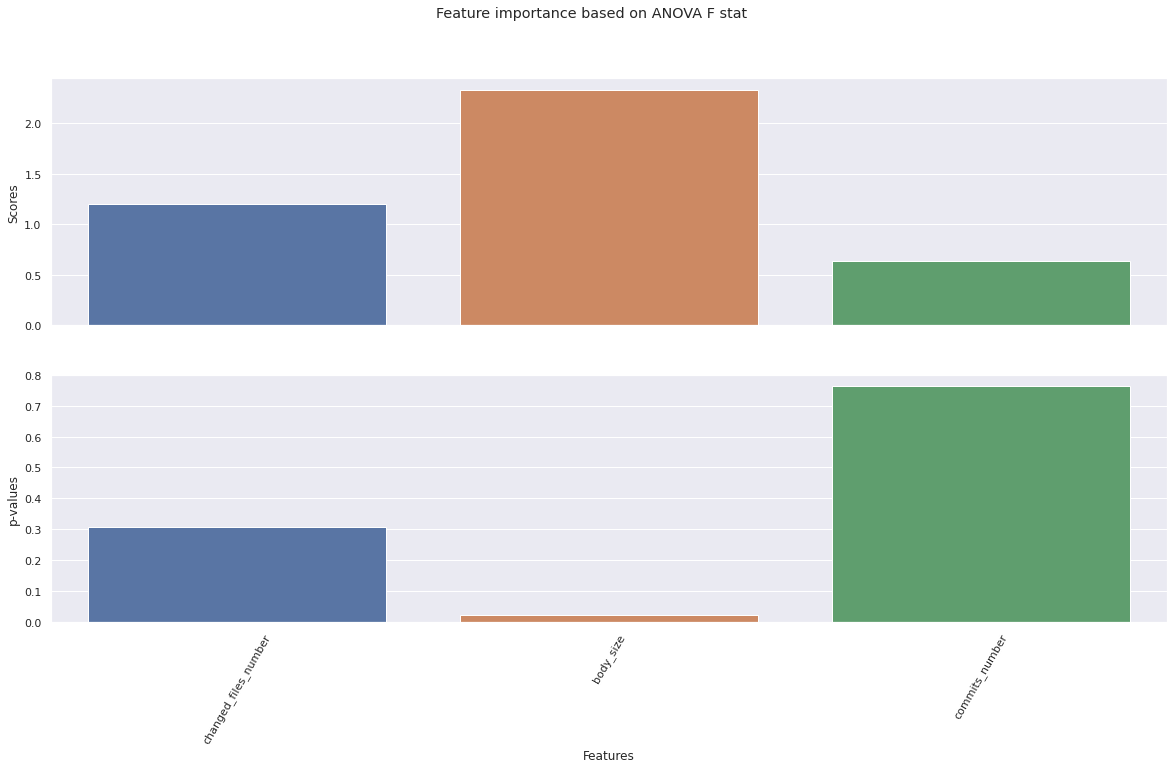

In [80]:
# create k best feature selector object based on anova f statistic
numerical_feats_f, k_best_selector_f = select_features(
    X_inp,
    y,
    f_classif,
)

# visualize the f stat scores and pvalues of all features
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Feature importance based on ANOVA F stat")
sns.barplot(x=X_inp.columns, y=k_best_selector_f.scores_, ax=axes[0])
sns.barplot(x=X_inp.columns, y=k_best_selector_f.pvalues_, ax=axes[1])
plt.xticks(rotation=60)
plt.xlabel("Features")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("p-values")
plt.show()

In [81]:
top_mi = k_best_selector_mi.scores_.argsort()[-3:][::-1]
top_anova = k_best_selector_f.scores_.argsort()[-3:][::-1]
union = set(top_mi).union(set(top_anova))
union

{0, 1, 2}

In [82]:
selected_num_features = [numerical_features[i] for i in union]
selected_num_features

['changed_files_number', 'body_size', 'commits_number']

In [83]:
# update list of features to keep for training
selected_features += selected_num_features

### Count Vector Type Features

Finally, lets determine the most important features from the count vector type columns.

In [84]:
# explode the list column so that there is 1 column representing frequency of each file type
filetype_df = pd.DataFrame(feature_df.changed_file_type_vec.to_list())
filetype_df.index = feature_df.index
filetype_df.columns = [f"filetype_{f}" for f in top_fileextensions]

In [85]:
# compute correlation with ttm
corr = filetype_df.corrwith(feature_df["ttm_class"])
corr.sort_values(ascending=False)

filetype_OWNERS            0.119971
filetype_.yaml             0.085867
filetype_.tmpl             0.056342
filetype_.json             0.026819
filetype_OWNERS_ALIASES   -0.010691
filetype_.txt             -0.041173
filetype_.md              -0.059820
filetype_.ipynb           -0.063092
filetype_.png             -0.070761
filetype_.yml             -0.118563
dtype: float64

In [86]:
corr[corr.abs() > 0.01]

filetype_.md              -0.059820
filetype_.yaml             0.085867
filetype_.tmpl             0.056342
filetype_OWNERS            0.119971
filetype_OWNERS_ALIASES   -0.010691
filetype_.yml             -0.118563
filetype_.ipynb           -0.063092
filetype_.png             -0.070761
filetype_.txt             -0.041173
filetype_.json             0.026819
dtype: float64

In [87]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
filetype_keep_cols = corr[corr.abs() > 0.01].index.tolist()
selected_features += filetype_keep_cols

# only keep the relevant columns now
filetype_df = filetype_df[filetype_keep_cols]

In [88]:
filetype_keep_cols = [i[9:] for i in filetype_keep_cols]
filetype_keep_cols

['.md',
 '.yaml',
 '.tmpl',
 'OWNERS',
 'OWNERS_ALIASES',
 '.yml',
 '.ipynb',
 '.png',
 '.txt',
 '.json']

In [89]:
filetype_keep_cols_df = pd.DataFrame(filetype_keep_cols, columns=["filetype"])

In [90]:
filetype_keep_cols_df

,filetype
0,.md
1,.yaml
2,.tmpl
3,OWNERS
4,OWNERS_ALIASES
5,.yml
6,.ipynb
7,.png
8,.txt
9,.json


In [91]:
FILETYPE_FEATURES_FILENAME = os.path.join(ORG + REPO + "FILETYPE.parquet")
FILETYPE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(
    filetype_keep_cols_df, FILETYPE_FEATURES_KEY, FILETYPE_FEATURES_FILENAME
)

{'ResponseMetadata': {'RequestId': 'l8ozfnqc-8qltis-g1t',
  'HostId': 'l8ozfnqc-8qltis-g1t',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'l8ozfnqc-8qltis-g1t',
   'x-amz-id-2': 'l8ozfnqc-8qltis-g1t',
   'access-control-allow-origin': '*',
   'access-control-allow-credentials': 'true',
   'access-control-allow-methods': 'GET,POST,PUT,DELETE,OPTIONS',
   'access-control-allow-headers': 'Content-Type,Content-MD5,Authorization,X-Amz-User-Agent,X-Amz-Date,ETag,X-Amz-Content-Sha256',
   'access-control-expose-headers': 'ETag,X-Amz-Version-Id',
   'etag': '"8487c851b09e86659776890a41880f48"',
   'date': 'Fri, 30 Sep 2022 21:13:30 GMT',
   'keep-alive': 'timeout=5',
   'content-length': '0',
   'set-cookie': '1a4aa612fe797ac8466d7ee00e5520d5=a26d7dd2bae782e2ad6181b7887b5ff1; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"8487c851b09e86659776890a41880f48"'}

In [92]:
# explode the list column so that there is 1 column representing frequency of each word
title_wordcount_df = pd.DataFrame(feature_df.title_word_counts_vec.to_list())

title_wordcount_df.index = feature_df.index
title_wordcount_df.columns = [f"title_wordcount_{w}" for w in unique_words]

In [93]:
# compute correlation with ttm
corr = title_wordcount_df.corrwith(feature_df["ttm_class"])
corr = corr.dropna()
corr.sort_values(ascending=False)

title_wordcount_charter      0.232491
title_wordcount_minor        0.225649
title_wordcount_details      0.225649
title_wordcount_docs         0.219837
title_wordcount_services     0.205797
                               ...   
title_wordcount_create      -0.245856
title_wordcount_hours       -0.251956
title_wordcount_office      -0.251956
title_wordcount_gitaction   -0.251956
title_wordcount_path        -0.251956
Length: 221, dtype: float64

In [94]:
corr[corr.abs() > 0.04]

title_wordcount_19_meeting       -0.143160
title_wordcount_26_meeting       -0.143160
title_wordcount_@margarethaley   -0.041173
title_wordcount_action           -0.106907
title_wordcount_actions          -0.109164
                                    ...   
title_wordcount_weekly           -0.109164
title_wordcount_wg                0.046865
title_wordcount_word              0.094810
title_wordcount_wording          -0.177156
title_wordcount_workload          0.060815
Length: 175, dtype: float64

In [95]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
title_word_keep_cols = corr[corr.abs() > 0.04].index.tolist()
selected_features += title_word_keep_cols

title_wordcount_df = title_wordcount_df[title_word_keep_cols]

In [96]:
title_word_keep_cols = [i[16:] for i in title_word_keep_cols]
title_word_keep_cols

['19_meeting',
 '26_meeting',
 '@margarethaley',
 'action',
 'actions',
 'add',
 'added',
 'adding',
 'addition',
 'airgapped',
 'analysis',
 'approach',
 'around',
 'bad',
 'bi',
 'build',
 'calendar',
 'carlosgimeno',
 'catalog',
 'change',
 'changes',
 'charter',
 'checklist',
 'chore',
 'clarity',
 'clean',
 'cluster',
 'complete',
 'completion',
 'context',
 'contrib_x',
 'contributors',
 'corrections',
 'create',
 'created',
 'creation',
 'curator',
 'data',
 'definition',
 'dependencies',
 'details',
 'dir',
 'directory',
 'discussion',
 'docs',
 'document',
 'ds',
 'dynamics',
 'evolving',
 'existing',
 'faq',
 'feat',
 'file',
 'first',
 'fix',
 'fixed',
 'fixes',
 'fixing',
 'follow',
 'forgotten',
 'forming',
 'fybrik',
 'gap',
 'generator',
 'git',
 'gitaction',
 'github',
 'give',
 'governance',
 'group',
 'groups',
 'guide',
 'hacking',
 'highlighting',
 'hours',
 'inclusive',
 'interactions',
 'internal_contributors',
 'jbook',
 'july',
 'jupyterbook',
 'kickoff',
 'lang

In [97]:
title_word_keep_cols_df = pd.DataFrame(title_word_keep_cols, columns=["title"])

In [98]:
title_word_keep_cols_df

,title
0,19_meeting
1,26_meeting
2,@margarethaley
3,action
4,actions
...,...
170,weekly
171,wg
172,word
173,wording


In [99]:
TITLE_FEATURES_FILENAME = os.path.join(ORG + REPO + "titlewords.parquet")
TITLE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(title_word_keep_cols_df, TITLE_FEATURES_KEY, TITLE_FEATURES_FILENAME)

{'ResponseMetadata': {'RequestId': 'l8ozfo8n-333tt4-xk2',
  'HostId': 'l8ozfo8n-333tt4-xk2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'l8ozfo8n-333tt4-xk2',
   'x-amz-id-2': 'l8ozfo8n-333tt4-xk2',
   'access-control-allow-origin': '*',
   'access-control-allow-credentials': 'true',
   'access-control-allow-methods': 'GET,POST,PUT,DELETE,OPTIONS',
   'access-control-allow-headers': 'Content-Type,Content-MD5,Authorization,X-Amz-User-Agent,X-Amz-Date,ETag,X-Amz-Content-Sha256',
   'access-control-expose-headers': 'ETag,X-Amz-Version-Id',
   'etag': '"fa0c8a2fc32448f37f3a2792a4091eea"',
   'date': 'Fri, 30 Sep 2022 21:13:30 GMT',
   'keep-alive': 'timeout=5',
   'content-length': '0',
   'set-cookie': '1a4aa612fe797ac8466d7ee00e5520d5=a26d7dd2bae782e2ad6181b7887b5ff1; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"fa0c8a2fc32448f37f3a2792a4091eea"'}

Using various feature importance scores such as chi-squared, mutual information statistic, correlation values, we have selected the most relevant features amongst all of our features. 

In [100]:
selected_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour',
 'changed_files_number',
 'body_size',
 'commits_number',
 'filetype_.md',
 'filetype_.yaml',
 'filetype_.tmpl',
 'filetype_OWNERS',
 'filetype_OWNERS_ALIASES',
 'filetype_.yml',
 'filetype_.ipynb',
 'filetype_.png',
 'filetype_.txt',
 'filetype_.json',
 'title_wordcount_19_meeting',
 'title_wordcount_26_meeting',
 'title_wordcount_@margarethaley',
 'title_wordcount_action',
 'title_wordcount_actions',
 'title_wordcount_add',
 'title_wordcount_added',
 'title_wordcount_adding',
 'title_wordcount_addition',
 'title_wordcount_airgapped',
 'title_wordcount_analysis',
 'title_wordcount_approach',
 'title_wordcount_around',
 'title_wordcount_bad',
 'title_wordcount_bi',
 'title_wordcount_build',
 'title_wordcount_calendar',
 'title_wordcount_carlosgimeno',
 'title_wordcount_catalog',
 'title_wordcount_change',
 'title_wordcount_changes',
 'title_wordcount_charter',
 'title_wordcount_checklist',
 'tit

## Save Feature Engineered Dataset

In [101]:
# join all types of features
ttm_dataset = pd.concat(
    [feature_df, filetype_df, title_wordcount_df], axis=1, ignore_index=False
)

# keep only the selected features and the prediction label
ttm_dataset = ttm_dataset[selected_features + ["ttm_class", "time_to_merge"]]

ttm_dataset.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.md,filetype_.yaml,...,title_wordcount_watercooler,title_wordcount_website,title_wordcount_week,title_wordcount_weekly,title_wordcount_wg,title_wordcount_word,title_wordcount_wording,title_wordcount_workload,ttm_class,time_to_merge
0,0,19,9,0,20,1,6,2,1,0,...,0,0,0,0,0,0,1,0,0,11.0
1,2,13,9,1,14,8,9,1,6,1,...,0,0,0,0,0,0,0,0,0,20.0
2,0,13,9,1,14,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,15.0
3,1,7,9,2,15,1,20,2,1,0,...,0,0,0,0,0,0,0,0,5,82496.0
4,3,29,8,0,19,1,22,1,1,0,...,0,0,0,0,0,0,0,0,9,NaN


In [102]:
ttm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Columns: 195 entries, size to time_to_merge
dtypes: float64(1), int64(194)
memory usage: 137.2 KB


## Save results to Ceph or locally

Using the helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [103]:
TTM_DATASET_PATH = os.path.join(s3_input_data_path, ORG, REPO)

In [104]:
## Sanity check to see if the dataset is the same

if REMOTE:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    try:
        cc.upload_to_ceph(
            ttm_dataset,
            TTM_DATASET_PATH,
            "ttm_feature_engineered_dataset.parquet",
        )
    except ValueError as ve:
        print(ve)
        print("Files already uploaded to S3")

else:
    save_to_disk(
        ttm_dataset,
        local_output_data_path,
        "ttm_dataset.parquet",
    )

### Check contents of the S3 bucket so far

In [105]:
# check all raw data files in s3
bucket = cc.s3_resource.Bucket(s3_bucket)
objects = [i for i in bucket.objects.all() if s3_input_data_path + "/" in i.key]
sorted(objects, key=lambda x: x.key)

[s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/operate-first/community/features/operate-firstcommunityFILETYPE.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/operate-first/community/features/operate-firstcommunitytitlewords.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/operate-first/community/sql/operate-firstcommunityprs.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/operate-first/community/test-data/X_test.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/operate-first/community/test-data/y_test.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/operate-first/community/ttm-model/model.joblib'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/operate-first/community/ttm_feature_engineered_dataset.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='oindrillac/srcopsmetrics/bot_knowledge/operate-first/c

# Conclusion

This notebook walked through how to access saved raw Pull Requests data from the previous data collection notebook and we engineered some possible features which can be used to predict time to merge of a PR. 

The features we engineered are as following:

- time_to_merge: time taken to merge a PR in seconds, this is feature we will try to predict
- changed_files_number: integer indicating the number of files changed, this is an available column
- body_size: integer indicating the number of words in the body of the PR, derived from body
- size: integer corresponding to a categorical label generated by GitHub which summarizes the size of the changes made to the code base 
- title_word_counts_vec: vector or list indicating how many times each word appeared in the title
- created_at_day: categorical variable indicating the day of month the PR has been created, derived from created_at
- created_at_month: categorical variable indicating the month of the year that the PR has been created, derived from created_at
- created_at_weekday: categorical variable indicating the day of the week the PR has been created, derived from created_at
- created_at_hour: categorical variable indicating the hour of the day the PR has been created, derived from created_at
- commits_number: integer indicating the number of commits in the PR
- changed_file_type_vec:  vector or list consisting of number of files changed for the top 100 most frequently occurring data types, derived from changed_files


# Next Step

In the next [notebook](./03_model_training.ipynb), we will train a classifier to predict time to merge of a PR using the features.